1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-life $\tau$ of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

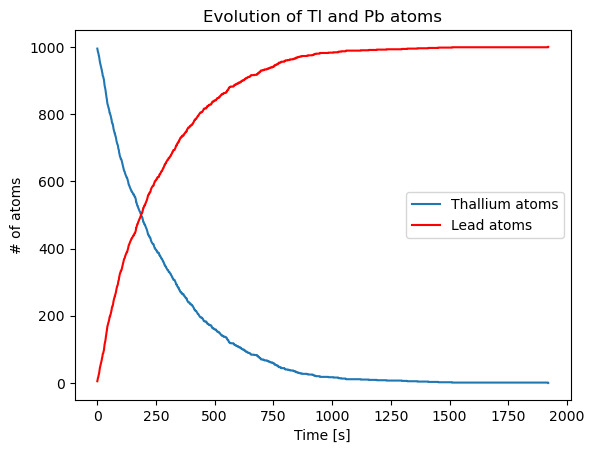

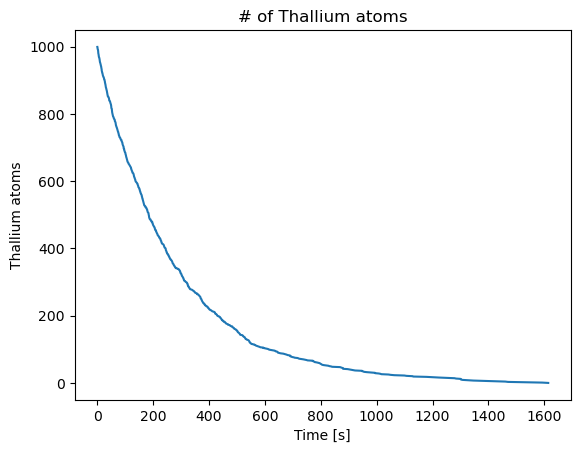

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def prob(t):
    return 1-2**(-t/(3.052*60))

thallium = 1000
lead = 0
#i assign to each atoms a probability where it decays
decade_time = np.random.rand(1000)
s=1
ntl = []
npb = []
#while not all Tl atoms are decayed
while lead<1000:
    p = prob(s)
    d = 0
    #check with a mask how many atoms have decayed
    mask = np.where(decade_time>p)
    new_decade = decade_time[mask]
    d = len(decade_time)-len(new_decade)
    #update the count
    thallium=thallium-d
    lead=lead+d
    #print("After",s,"seconds",d,"atoms of thallium decaded and became lead.")
    #print("We now have",thallium,"atoms of thallium and",lead,"atoms of lead.\n")
    s=s+1
    decade_time = new_decade
    #append the numbers of atoms to keep track of evolution
    ntl.append(thallium)
    npb.append(lead)

#create the time axis
t=np.arange(len(npb))
#plot the evolution over time
plt.figure()
plt.plot(t, ntl, label="Thallium atoms")
plt.plot(t, npb, color="r", label="Lead atoms")
plt.title('Evolution of Tl and Pb atoms')
plt.xlabel('Time [s]')
plt.ylabel('# of atoms')
plt.legend()
plt.show()

def inv_decay(y):
    tau = 3.052*60
    return - tau*np.log2(1-y)

#again assign to each atom a probability
athoms_prob = np.random.rand(1000)
#calculate the time at which it decay with the inverse of the decay probability
decay_time = inv_decay(athoms_prob)
#sort it in the inverse order
decay_time_sorted = np.sort(decay_time)[::-1]
#create the number of atoms which we have at each time step
n = np.arange(1000)
#plot the evolution over time
plt.figure()
plt.plot(decay_time_sorted, n)
plt.title("# of Thallium atoms")
plt.xlabel("Time [s]")
plt.ylabel("Thallium atoms")
plt.show()

2\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function: 

$$f(x) =\sin^2{\left( \frac{1}{1-x} \right)}$$

* Plot the function and compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate (hint: repeat the integral $N$ times, and from the distribution of the integrals take the mean value and the standard deviation, the latter rescaled by the appropriate factor)
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one.

With the hit/miss method the estimated value of the integral is 1.357
The estimated error is 0.015356


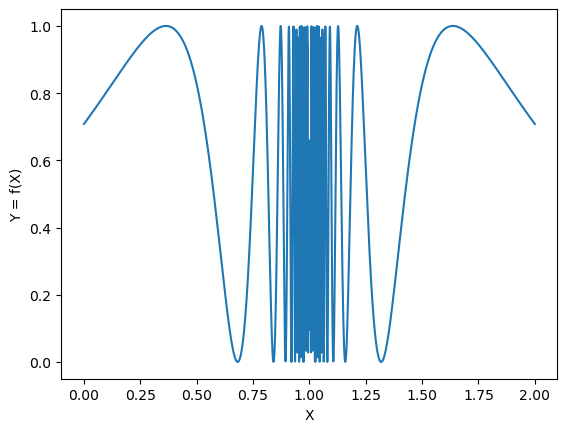

The mean value method gives an integral value of 1.35435362731562
The estimated error is 0.019684
The hit/miss method leads to a smaller error


In [2]:
def f(x):
    return (np.sin(1/(1-x)))**2

#Set the boundaries
n = 2000
h, a, b = 1, 0, 2
c = 0
#Repeat n times the hit/miss procedure
for i in range(n):
    #generate x in the [a,b] interval and y in [0,1]
    y = h * np.random.rand()
    x = (b - a) * np.random.rand()
    if y<f(x):
        c = c+1
I = (c/n) * h*(b - a)
print("With the hit/miss method the estimated value of the integral is", I)
#testing to find the error
m = 9
Im = np.zeros(m)
for i in range(m):
    c=0
    #repeat the calculation m times
    for j in range(n):
        y = h * np.random.rand()
        x = (b - a) * np.random.rand()
        if y<f(x):
            c = c+1
    Im[i]=(c/n) * h*(b - a)
I1 = np.sum(Im)/m
I2 = np.sum(Im**2)/m
sM = np.sqrt( I2 - I1**2 )
print("The estimated error is {:.6f}".format(sM))
#plot the function
test = np.linspace(0, 2, n)
plt.figure()
plt.plot(test, f(test))
plt.xlabel("X")
plt.ylabel("Y = f(X)")
plt.show()

#Now with the mean value method
somma=0
for i in range(n):
    somma = somma+f(a+(b-a)*np.random.rand())
J = ((b-a)/n) * somma
print("The mean value method gives an integral value of", J)

#Repeat the test for the mean method
Im = np.zeros(m)
for i in range(m):
    somma=0
    for j in range(n):
        somma = somma+f(a+(b-a)*np.random.rand())
    Im[i] = ((b-a)/n) * somma
I1 = np.sum(Im)/m
I2 = np.sum(Im**2)/m
mean_sM = np.sqrt( I2 - I1**2 )
print("The estimated error is {:.6f}".format(mean_sM))
if mean_sM<sM:
    print("The mean value method leads to a smaller error")
else:
    print("The hit/miss method leads to a smaller error")

3\. **Monte Carlo integration in high dimension**

* Compute the area of a circle of unit radius, by integrating the function:

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere.

In [3]:
def circle(x):
    out = 1
    if np.sum(x**2) > 1:
        out = 0
    return out

n = 5000
dim = 10
somma = 0
#set the boundaries in all dimensions
h = np.ones(dim)
#perform the mean value method
for i in range(n):
    somma = somma+circle(h*np.random.rand())
J = ((2**dim) / n) * somma
print("The estimated area of the circle with", dim, "dimensions is", J)

The estimated area of the circle with 10 dimensions is 328.0896


4\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should expect a result around 0.84.

In [6]:
def f(x):
    return (x**-0.5)/(np.exp(x)+1)
def w(x):
    return 1/np.sqrt(x)
def prim_w(x):
    return 2*np.sqrt(x)

n=2000
a,b=0,1
somma=0
iW=prim_w(b)-prim_w(a)
for i in range(n):
    x=a+(b-a)*np.random.rand()
    somma = somma+f(x)/w(x)
iF = ((b-a)/n) * somma
I = iF * iW
print("The estimated integral result is", I)

The estimated integral result is 0.7595367945879556
